In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main

/content/gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# Training loop
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
from torch.nn.utils.rnn import pad_sequence


In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:100000]
data_norm_anom = data_norm_anom.dropna()

df_normal = data_norm_anom[data_norm_anom['Label'] == 0]
df_normal = df_normal.iloc[:, 0:-1]
df_normal.shape

(93873, 26)

In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:20000]
data_norm_anom = data_norm_anom.dropna()

df_anomaly = data_norm_anom[data_norm_anom['Label'] == 1]
df_anomaly = df_anomaly.iloc[:, 0:-1]
df_anomaly.shape

In [ ]:
df_anomaly = df_anomaly.values
df_anomaly.shape

In [ ]:
df_normal = df_normal.values
df_normal.shape

(93873, 26)

In [ ]:
import numpy as np
import random

class SyntheticAnomalyGenerator:
    def __init__(self,
                 window_size,
                 reference_anomalies,
                 anomaly_types=['local_perturbation']):
        """
        Initializes the anomaly generator that oversamples real anomaly data
        but applies small perturbations to create a local neighborhood around
        the real anomalies.

        Args:
            window_size (int): The size of the anomaly window to inject.
            reference_anomalies (np.ndarray): Real anomaly data from which to oversample.
              Shape could be (num_anomalies, sequence_length, num_features) or
              (num_anomalies, num_features) if each row is a snippet, etc.
            anomaly_types (list): We keep it flexible, but default to ['local_perturbation'].
        """
        self.anomaly_types = anomaly_types
        self.window_size = window_size

        # Real anomaly data to oversample from
        self.reference_anomalies = reference_anomalies

    def inject_anomaly_into_sequence(self, sequence):
        """
        Called externally to inject an anomaly into 'sequence' by
        picking a real anomaly snippet, perturbing it, and overlaying.
        """
        anomalous_sequence = sequence.copy()
        anomaly_type = random.choice(self.anomaly_types)

        seq_length, num_features = anomalous_sequence.shape

        if seq_length <= self.window_size:
            t0 = 0
            t1 = seq_length
        else:
            t0 = random.randint(0, seq_length - self.window_size)
            t1 = t0 + self.window_size

        if anomaly_type == 'local_perturbation':
            anomalous_sequence = self.local_perturbation_injection(anomalous_sequence, t0, t1)
        elif anomaly_type == 'permutation_anomaly':
            # optional, if you want partial permutations
            anomalous_sequence = self.permutation_anomaly(anomalous_sequence, t0, t1)

        return anomalous_sequence

    def local_perturbation_injection(self, sequence, t0, t1):
        """
        1) Randomly pick a real anomaly snippet from reference_anomalies.
        2) Possibly adapt or clamp it to 'window_size'.
        3) Add small random perturbations (noise, slight scaling, partial permutations, etc.).
        4) Overlay onto 'sequence[t0:t1]'.
        """
        anomalous_sequence = sequence.copy()
        window_length = t1 - t0
        seq_length, num_features = anomalous_sequence.shape

        # 1) pick a random anomaly snippet from reference_anomalies
        #    Suppose reference_anomalies has shape (num_anomalies, anomaly_length, num_features)
        #    or (num_anomalies, num_features) if each row is a snippet.
        rand_idx = random.randint(0, self.reference_anomalies.shape[0]-1)
        real_anomaly_snippet = self.reference_anomalies[rand_idx]

        # Check if real_anomaly_snippet is 2D or 1D
        if real_anomaly_snippet.ndim == 1:
            # shape (num_features,) => we replicate or clamp it
            # e.g. we'll just tile it for 'window_length'
            real_anomaly_snippet = np.tile(real_anomaly_snippet, (window_length,1))
        elif real_anomaly_snippet.shape[0] != window_length:
            # We do a clamp or pad approach:
            real_len = real_anomaly_snippet.shape[0]
            if real_len > window_length:
                # clamp
                start_ = random.randint(0, real_len - window_length)
                real_anomaly_snippet = real_anomaly_snippet[start_:start_+window_length, :]
            else:
                # if real_len < window_length => pad repeats or edge
                repeats_needed = window_length - real_len
                # simplest => tile or pad
                real_anomaly_snippet = np.concatenate([
                    real_anomaly_snippet,
                    np.tile(real_anomaly_snippet[-1,:], (repeats_needed,1))
                ], axis=0)

        # Now real_anomaly_snippet is shape (window_length, num_features)

        # 2) Add small perturbations
        perturbed_snippet = self.apply_small_perturbations(real_anomaly_snippet)

        # 3) Overlay
        anomalous_sequence[t0:t1] = perturbed_snippet
        return anomalous_sequence

    def apply_small_perturbations(self, snippet):
        """
        snippet shape: (window_length, num_features)
        We'll do e.g.:
          - small gaussian noise
          - slight random scaling per feature
          - partial permutations of a few rows (rare)
        all to keep changes mild.
        """
        w_len, n_feats = snippet.shape
        snippet_ = snippet.copy()

        # A) small gaussian noise
        noise_std = 0.05 * np.std(snippet_)  # e.g. 5% of snippet's std
        noise = np.random.normal(0, noise_std, snippet_.shape)
        snippet_ += noise

        # B) slight random scaling per feature
        # e.g. each feature f => scale_f in [0.95,1.05]
        scales = 0.95 + 0.1*np.random.rand(n_feats)
        for f in range(n_feats):
            snippet_[:, f] *= scales[f]

        # C) partial row permutation, only a few rows
        # e.g. we permute 10% of the snippet rows:
        row_count = int(0.1 * w_len)  # 10% of rows
        if row_count>1:
            perm_indices = np.random.choice(w_len, size=row_count, replace=False)
            # shuffle those rows
            snippet_[perm_indices] = snippet_[np.random.permutation(perm_indices)]

        return snippet_

    def permutation_anomaly(self, sequence, t0, t1):
        """
        If you want a direct 'permutation_anomaly' approach:
        """
        anomalous_sequence = sequence.copy()
        window = anomalous_sequence[t0:t1]
        perm_indices = np.random.permutation(len(window))
        permuted_window = window[perm_indices]
        anomalous_sequence[t0:t1] = permuted_window
        return anomalous_sequence


In [ ]:
def extract_sequences(time_series_data, window_size, step_size):
    total_length, num_features = time_series_data.shape
    sequences = []

    for start_idx in range(0, total_length - window_size + 1, step_size):
        end_idx = start_idx + window_size
        sequence = time_series_data[start_idx:end_idx]
        sequences.append(sequence)

    return sequences

In [ ]:
def generate_consecutive_pairs(sequences, sequence_labels):
    """
    Generate pairs of consecutive sequences.

    Args:
        sequences (list): List of sequences.
        sequence_labels (list): Corresponding labels for each sequence.

    Returns:
        x1_pairs (list): List of sequences for x1.
        x2_pairs (list): List of sequences for x2.
        pair_labels (list): List of labels for each pair (0 for normal-normal, 1 for anomaly-involved).
    """
    x1_pairs = []
    x2_pairs = []
    pair_labels = []

    for i in range(len(sequences) - 1):
        x1 = sequences[i]
        x2 = sequences[i + 1]
        label = 0  # Default to normal-normal

        # If either sequence is anomalous, label the pair as anomaly-involved
        if sequence_labels[i] == 1 or sequence_labels[i + 1] == 1:
            label = 1

        x1_pairs.append(x1)
        x2_pairs.append(x2)
        pair_labels.append(label)

    return x1_pairs, x2_pairs, pair_labels


In [ ]:
def collate_fn(batch):
    x1_batch, x2_batch, labels = zip(*batch)

    x1_batch = [torch.tensor(x, dtype=torch.float32) for x in x1_batch]
    x2_batch = [torch.tensor(x, dtype=torch.float32) for x in x2_batch]

    x1_lengths = torch.tensor([seq.size(0) for seq in x1_batch], dtype=torch.long)
    x2_lengths = torch.tensor([seq.size(0) for seq in x2_batch], dtype=torch.long)

    padded_x1 = pad_sequence(x1_batch, batch_first=True, padding_value=0.0)
    padded_x2 = pad_sequence(x2_batch, batch_first=True, padding_value=0.0)

    labels = torch.tensor(labels, dtype=torch.float32)  # For contrastive loss, labels should be float

    max_len_x1 = padded_x1.size(1)
    max_len_x2 = padded_x2.size(1)

    range_x1 = torch.arange(max_len_x1).unsqueeze(0).expand(len(x1_lengths), max_len_x1)
    range_x2 = torch.arange(max_len_x2).unsqueeze(0).expand(len(x2_lengths), max_len_x2)

    x1_mask = (range_x1 >= x1_lengths.unsqueeze(1)).to(torch.bool)
    x2_mask = (range_x2 >= x2_lengths.unsqueeze(1)).to(torch.bool)

    return padded_x1, padded_x2, labels, x1_mask, x2_mask


In [ ]:
def apply_synthetic_anomalies_to_sequences(sequences, anomaly_percentage, anomaly_generator):
    """
    Inject synthetic anomalies into a specified percentage of sequences.

    Args:
        sequences (list): List of sequences extracted from the time series data.
        anomaly_percentage (float): Percentage of sequences to inject anomalies (0.1 to 1.0).
        anomaly_generator (SyntheticAnomalyGenerator): An instance of the anomaly generator.

    Returns:
        augmented_sequences (list): List of sequences after injecting anomalies.
        sequence_labels (list): Labels for each sequence (0 for normal, 1 for anomaly).
    """
    num_sequences = len(sequences)
    num_anomalous_sequences = int(num_sequences * anomaly_percentage)
    anomaly_indices = set(random.sample(range(num_sequences), num_anomalous_sequences))

    augmented_sequences = []
    sequence_labels = []

    for i, seq in enumerate(sequences):
        if i in anomaly_indices:
            # Inject anomaly into the entire sequence
            augmented_seq = anomaly_generator.inject_anomaly_into_sequence(seq)
            augmented_sequences.append(augmented_seq)
            sequence_labels.append(1)
        else:
            # Normal sequence
            augmented_sequences.append(seq)
            sequence_labels.append(0)

    return augmented_sequences, sequence_labels


In [ ]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x1_pairs, x2_pairs, pair_labels, transform=None):
        assert len(x1_pairs) == len(x2_pairs) == len(pair_labels), "All inputs must have the same length."
        self.x1_pairs = x1_pairs
        self.x2_pairs = x2_pairs
        self.pair_labels = pair_labels
        self.transform = transform

    def __len__(self):
        return len(self.pair_labels)

    def __getitem__(self, idx):
        x1 = self.x1_pairs[idx]
        x2 = self.x2_pairs[idx]
        label = self.pair_labels[idx]

        if self.transform:
            x1 = self.transform(x1)
            x2 = self.transform(x2)

        return x1, x2, label


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.output_proj = nn.Linear(model_dim, model_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x = self.input_proj(x)  # (batch_size, seq_length, model_dim)
        x = self.dropout(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, seq_length, model_dim)

        if src_key_padding_mask is not None:
            # Create data mask: True where data is present
            data_mask = (~src_key_padding_mask).unsqueeze(2).type_as(x)  # (batch_size, seq_length, 1)
            x = x * data_mask  # Zero out padding positions: (batch_size, seq_length, model_dim)
            x_sum = x.sum(dim=1)  # Sum over seq_length: (batch_size, model_dim)

            lengths = data_mask.sum(dim=1)  # Sum over seq_length: (batch_size, 1)
            lengths = lengths.clamp(min=1)  # Avoid division by zero
            x = x_sum / lengths  # (batch_size, model_dim)
        else:
            x = x.mean(dim=1)  # Average over seq_length: (batch_size, model_dim)

        x = self.output_proj(x)  # (batch_size, model_dim)
        x = self.activation(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Normal(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Normal, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Anomaly(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Anomaly, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [ ]:
import torch.nn.functional as F

def contrastive_loss(ll_gaussian, ll_vine, pair_labels, alpha=0.5, base_margin= 0.0):
    """
      A contrastive loss for separating normal vs. anomaly log-likelihoods with a *dynamic* margin:

      1) Normal frames => maximize log-likelihood => loss = -LL_normal
      2) Anomaly frames => LL_anomaly <= (mean_normal_LL - base_offset) on a per-sample basis.

    Now we receive both Gaussian and Studen-t LL. We pick the appropriate LL based on the labels:
    - Normal pairs (label=0) -> Gaussian Copula LL
    - Anomaly pairs (label=1) -> Vine Copula LL
    """
    pair_labels = pair_labels.view(-1)
    # Select appropriate LL based on labels
    chosen_ll = torch.where(pair_labels == 0, ll_gaussian, ll_vine)

    normal_ll = chosen_ll[pair_labels == 0]
    anomaly_ll = chosen_ll[pair_labels == 1]
    #print (f"Normal LL: {normal_ll.mean()}")
    #print (f"Anomaly LL: {anomaly_ll.mean()}")

    if len(normal_ll) > 0:
        loss_normal = -normal_ll
        mean_normal_ll = normal_ll.mean()
    else:
        loss_normal = torch.tensor(0.0, device=chosen_ll.device)
        mean_normal_ll = torch.tensor(0.0, device=chosen_ll.device)

    # -----------------------
    # Anomaly portion
    # -----------------------
    # We'll define a *dynamic margin* for anomalies
    # margin_dyn = mean_normal_ll - base_offset
    # Then for each anomaly sample 'a', we want a <= margin_dyn => diff = a - margin_dyn => F.relu(diff)
    # If diff>0 => penalty
    if len(anomaly_ll) > 0:
        margin_dyn = mean_normal_ll - base_margin
        # shape (#anomalies,)
        diff = anomaly_ll - margin_dyn
        # sample-level margin
        loss_anomaly = alpha * F.relu(diff).mean()
    else:
        loss_anomaly = torch.tensor(0.0, device=device)

    total_loss = (1 - alpha) * loss_normal.mean() + loss_anomaly.mean()


      # Monitoring: Print average log-likelihoods for debugging
    if len(normal_ll) > 0:
        print(f"Contrastive Loss - Normal LL Mean: {loss_normal.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Normal Samples in Batch.")

    if len(anomaly_ll) > 0:
        print(f"Contrastive Loss - Anomalous LL Mean: {loss_anomaly.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Anomalous Samples in Batch.")

    return total_loss

In [ ]:
class AnomalyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout, embedding_dim=64):
        super(AnomalyTransformer, self).__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout)

        # We now have two different copulas
        self.gaussian_copula = StudentTCopula_Normal(latent_dim=2 * model_dim)
        self.vine_copula = StudentTCopula_Anomaly(latent_dim=2 * model_dim)

        self.embedding_layer = nn.Linear(2 * model_dim, embedding_dim)

    def forward(self, x1, x2, mask1=None, mask2=None):
        z1 = self.encoder(x1, src_key_padding_mask=mask1)
        z2 = self.encoder(x2, src_key_padding_mask=mask2)
        z = torch.cat((z1, z2), dim=1)

        # Compute both Gaussian and Vine likelihoods
        ll_gaussian = self.gaussian_copula(z)
        ll_vine = self.vine_copula(z)
        return ll_gaussian, ll_vine

    def get_embeddings(self, x1, x2, mask1=None, mask2=None):
        # Instead of passing x1, x2 as (B, features),
        # we do x1 => (B, 1, features)
        if x1.dim() == 2:
            x1 = x1.unsqueeze(1)  # shape => (B,1,features)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(1)

        transformed_x1 = self.encoder(x1, src_key_padding_mask=mask1)
        transformed_x2 = self.encoder(x2, src_key_padding_mask=mask2)

        # Now each is likely shape (B, seq_len=1, model_dim) or (B, model_dim)
        # if the encoder does a mean over seq_len => shape (B, model_dim).
        # We need to confirm the final shape. If the encoder returns 3D => e.g. (B,1,model_dim),
        # we might want to reduce it to 2D => (B,model_dim) by mean over dim=1.
        if transformed_x1.dim() == 3:
            # e.g. if shape => (B,1,hidden_dim), reduce to (B, hidden_dim)
            transformed_x1 = transformed_x1.mean(dim=1)
        if transformed_x2.dim() == 3:
            transformed_x2 = transformed_x2.mean(dim=1)

        # Now each => (B, hidden_dim)
        combined = torch.cat((transformed_x1, transformed_x2), dim=1)  # => (B,2*hidden_dim)
        embeddings = self.embedding_layer(combined)  # => (B, embed_dim)
        return embeddings

In [ ]:
#

In [ ]:
window_size = 100
step_size = 50  # Non-overlapping sequences
anomaly_percentage = 0.7 # 20% of sequences will be anomalous
batch_size = 64


# Step 1: Extract sequences from the raw data
sequences = extract_sequences(df_normal, window_size=window_size, step_size=step_size)
print(f"Total extracted sequences: {len(sequences)}")


anomaly_generator = SyntheticAnomalyGenerator(
    window_size=50,
    reference_anomalies=df_anomaly,
    anomaly_types=['local_perturbation']  # can add 'permutation_anomaly' if desired
)

# Step 2: Inject anomalies into sequences
augmented_sequences, sequence_labels = apply_synthetic_anomalies_to_sequences(
    sequences,
    anomaly_percentage=anomaly_percentage,
    anomaly_generator=anomaly_generator
)
print(f"Total anomalous sequences: {sum(sequence_labels)}")

# Step 3: Generate consecutive pairs
x1_pairs, x2_pairs, pair_labels = generate_consecutive_pairs(augmented_sequences, sequence_labels)
print(f"Total generated pairs: {len(pair_labels)}")
print(f"Anomaly-involved pairs: {sum(pair_labels)}")
print(f"Normal-normal pairs: {len(pair_labels) - sum(pair_labels)}")


Total extracted sequences: 1876
Total anomalous sequences: 1313
Total generated pairs: 1875
Anomaly-involved pairs: 1695
Normal-normal pairs: 180


In [ ]:
from torch.utils.data import DataLoader, Subset
import torch

# 1) Train dataset from x1_pairs, x2_pairs, pair_labels
train_dataset = TimeSeriesDataset(
    x1_pairs=x1_pairs,
    x2_pairs=x2_pairs,
    pair_labels=pair_labels,
    transform=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 2) Build a new dataset for the separate test data
import pandas as pd
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.dropna()

data_test = data_norm_anom.iloc[100000:200000]
test_features = data_test.iloc[:, :-1].values
test_labels   = data_test.iloc[:,  -1].values
print (test_features.shape, test_labels.shape)

(100000, 26) (100000,)


In [ ]:
# Define a simple dataset
class SimpleTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels   = labels
        self.transform= transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

test_dataset_all = SimpleTimeSeriesDataset(test_features, test_labels)

In [ ]:
# 3) Split that dataset into val + test
test_dataset_size = len(test_dataset_all)
val_size = test_dataset_size // 2
val_indices = list(range(val_size))
test_indices= list(range(val_size, test_dataset_size))

val_subset  = torch.utils.data.Subset(test_dataset_all, val_indices)
test_subset = torch.utils.data.Subset(test_dataset_all, test_indices)

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = df_normal.shape[1]  # Number of features in the input data
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.3

model = AnomalyTransformer(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


**PLOTTING AND STATS**


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch

# Function to calculate F1_PA
def calculate_f1_pa(labels, preds):
    true_segments = []
    pred_segments = []

    # Get segments for true labels
    i = 0
    while i < len(labels):
        if labels[i] == 1:
            start = i
            while i < len(labels) and labels[i] == 1:
                i += 1
            true_segments.append((start, i - 1))
        i += 1

    # Get segments for predictions
    i = 0
    while i < len(preds):
        if preds[i] == 1:
            start = i
            while i < len(preds) and preds[i] == 1:
                i += 1
            pred_segments.append((start, i - 1))
        i += 1

    # Compute overlap
    tp = 0
    for t_start, t_end in true_segments:
        for p_start, p_end in pred_segments:
            if not (p_end < t_start or p_start > t_end):
                tp += 1
                break

    precision_pa = tp / len(pred_segments) if len(pred_segments) > 0 else 0
    recall_pa = tp / len(true_segments) if len(true_segments) > 0 else 0
    f1_pa = 2 * precision_pa * recall_pa / (precision_pa + recall_pa) if precision_pa + recall_pa > 0 else 0

    return f1_pa


# Validation Function
def validate(model, val_loader, device, threshold=None):
    model.eval()
    all_log_likelihoods = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Check how many items are in the batch
            if len(batch) == 5:
                # The original multi-input scenario
                padded_x1, padded_x2, labels, x1_mask, x2_mask = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels = labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            if len(batch) == 3:
                padded_x1, padded_x2, labels = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels    = labels.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2)

            elif len(batch) == 2:
                features, labels = batch
                features = features.to(device, dtype=torch.float32)
                labels = labels.to(device)

                # Unsqueeze so shape => (B, 1, num_features)
                features = features.unsqueeze(1)

                ll_gaussian, ll_vine = model(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have (ll_gaussian, ll_vine) and 'labels'
            # Select final LL:  normal => Gaussian, anomaly => Vine
            ll_final = torch.where(labels == 0, ll_gaussian, ll_vine)

            all_log_likelihoods.extend(ll_final.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to np.array
    all_log_likelihoods = np.array(all_log_likelihoods)
    all_labels = np.array(all_labels)

    # If no threshold provided, find best by F1
    if threshold is None:
        best_f1 = 0.0
        best_threshold = 0.0
        mins, maxs = all_log_likelihoods.min(), all_log_likelihoods.max()
        for thresh in np.linspace(mins, maxs, 100):
            preds = (all_log_likelihoods < thresh).astype(int)
            f1 = f1_score(all_labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
        threshold = best_threshold

    # Generate final predictions using threshold
    preds = (all_log_likelihoods < threshold).astype(int)

    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    auc_roc = roc_auc_score(all_labels, -all_log_likelihoods)  # negative => lower LL => anomaly

    # Calculate F1_PA
    f1_pa = calculate_f1_pa(all_labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'f1_pa': f1_pa,
        'threshold': threshold
    }


In [ ]:
def plot_log_likelihoods(model, loader, device, dataset_name="Dataset"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torch import no_grad

    model.eval()
    log_likelihoods = []
    labels = []

    normal_log_likelihoods = []
    anomaly_log_likelihoods = []

    with no_grad():
        for batch in loader:
            if len(batch) == 5:
                # old approach: (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device)
                padded_x2 = padded_x2.to(device)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # model returns (ll_gaussian, ll_vine)
                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 2:
                # new approach: (features, labels)
                features, batch_labels = batch
                # shape => (batch_size, features) or (batch_size, seq_len, features)
                features = features.to(device, dtype=torch.float32)
                features = features.unsqueeze(1)  # => shape (B,1,features_dim)

                batch_labels = batch_labels.to(device)

                # If your model expects two inputs, we pass the same feature twice
                ll_gaussian, ll_vine = model(features, features)
            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have ll_gaussian, ll_vine, and batch_labels
            # Normal => label=0 => use ll_gaussian
            # Anomaly=> label=1 => use ll_vine
            selected_ll = torch.where(batch_labels == 0, ll_gaussian, ll_vine)

            # Convert to CPU/NumPy
            selected_ll_np = selected_ll.cpu().numpy()
            labels_np = batch_labels.cpu().numpy()

            # Separate normal vs. anomaly for debugging
            normal_mask = (labels_np == 0)
            anomaly_mask= (labels_np == 1)

            normal_ll  = selected_ll_np[normal_mask]
            anomaly_ll = selected_ll_np[anomaly_mask]

            if len(normal_ll) > 0:
                normal_log_likelihoods.extend(normal_ll)
            if len(anomaly_ll) > 0:
                anomaly_log_likelihoods.extend(anomaly_ll)

            log_likelihoods.extend(selected_ll_np)
            labels.extend(labels_np)

    log_likelihoods = np.array(log_likelihoods)
    labels = np.array(labels)

    # Build a DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame({
        'Log-Likelihood': log_likelihoods,
        'Label': ['Anomaly' if lb == 1 else 'Normal' for lb in labels]
    })

    # Summary stats
    if len(normal_log_likelihoods) > 0:
        mean_normal = np.mean(normal_log_likelihoods)
    else:
        mean_normal = float('nan')

    if len(anomaly_log_likelihoods) > 0:
        mean_anomaly = np.mean(anomaly_log_likelihoods)
    else:
        mean_anomaly = float('nan')

    print(f"[{dataset_name}] Mean Normal Log-Likelihood: {mean_normal:.4f}")
    print(f"[{dataset_name}] Mean Anomaly Log-Likelihood: {mean_anomaly:.4f}")

    # Plot distributions via Seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='Log-Likelihood', hue='Label', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Log-Likelihood Distribution for {dataset_name} Set')
    plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 25
epoch_losses = []
val_metrics_history = []

# Arrays to store metrics each epoch
auc_roc_values   = []
accuracy_values  = []
precision_values = []
recall_values    = []

# (If needed) define your LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_f1           = 0.0
patience_counter  = 0
patience          = 10

try:
    for epoch in range(num_epochs):
        ################################################
        # 1) TRAIN
        ################################################
        model.train()
        running_loss = 0.0

        for batch_idx, (padded_x1, padded_x2, labels, x1_mask, x2_mask) in enumerate(train_loader):
            padded_x1 = padded_x1.to(device)
            padded_x2 = padded_x2.to(device)
            labels    = labels.to(device)
            x1_mask   = x1_mask.to(device)
            x2_mask   = x2_mask.to(device)

            optimizer.zero_grad()

            # If your model returns (ll_gaussian, ll_vine), you might unify them,
            # but for now let's keep your existing logic:
            ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            loss = contrastive_loss(ll_gaussian, ll_vine, labels, alpha=0.3, base_margin=500.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        ################################################
        # 2) VALIDATE AFTER EVERY EPOCH
        ################################################
        val_metrics = validate(model, val_loader, device)
        print(f"Validation Metrics @ Epoch {epoch+1}: {val_metrics}")

        # Collect metrics
        auc_roc_values.append(val_metrics['auc_roc'])
        accuracy_values.append(val_metrics['accuracy'])
        precision_values.append(val_metrics['precision'])
        recall_values.append(val_metrics['recall'])

        # Example LR-scheduler usage (comment out if you don't need it)
        # scheduler.step(val_metrics['auc_roc'])

        ################################################
        # 3) PLOT LIKELIHOOD SEPARATION
        #    - Once at start: epoch == 0
        #    - Then every 2 epochs => (epoch+1)%2==0 => 2,4,6...
        ################################################
        if epoch == 0:
            print("\n>>> Plotting Log-Likelihoods at the start (Epoch 1) <<<")
            print("Training set separation:")
            plot_log_likelihoods(model, train_loader, device, dataset_name="Train-Epoch1")
            print("Validation set separation:")
            plot_log_likelihoods(model, val_loader, device, dataset_name="Val-Epoch1")

        elif (epoch + 1) % 2 == 0:
            print(f"\n>>> Plotting Log-Likelihoods after {epoch+1} epochs <<<")
            print("Training set separation:")
            plot_log_likelihoods(model, train_loader, device,
                                 dataset_name=f"Train-Epoch{epoch+1}")
            print("Validation set separation:")
            plot_log_likelihoods(model, val_loader, device,
                                 dataset_name=f"Val-Epoch{epoch+1}")

except KeyboardInterrupt:
    print("Training interrupted. Saving model...")

# After training, finalize, e.g.:
print("\n--- Final Evaluate on Training Set ---")
plot_log_likelihoods(model, train_loader, device, dataset_name="Train-Final")

print("\n--- Final Evaluate on Validation Set ---")
plot_log_likelihoods(model, val_loader, device, dataset_name="Val-Final")

# Save your model
torch.save(model.state_dict(), 'model_final.pth')

# Optionally reload, check
model_loaded = AnomalyTransformer(input_dim=input_dim,
                                  model_dim=model_dim,
                                  num_heads=num_heads,
                                  num_layers=num_layers,
                                  dropout=dropout).to(device)
model_loaded.load_state_dict(torch.load('model_final.pth'), strict=True)
model_loaded.eval()

print("\n--- Reloaded Model: Evaluate on Training ---")
plot_log_likelihoods(model_loaded, train_loader, device, dataset_name="Train Reloaded")

print("\n--- Reloaded Model: Evaluate on Validation ---")
plot_log_likelihoods(model_loaded, val_loader, device, dataset_name="Val Reloaded")

# If you want to plot your metrics:
import matplotlib.pyplot as plt
import numpy as np

epochs_array = np.arange(1, num_epochs+1)

plt.figure(figsize=(10,6))
plt.plot(epochs_array, auc_roc_values,    label="AUC",   marker='o')
plt.plot(epochs_array, accuracy_values,   label="Acc",   marker='s')
plt.plot(epochs_array, precision_values,  label="Prec",  marker='^')
plt.plot(epochs_array, recall_values,     label="Recall",marker='x')
plt.legend()
plt.title("Validation metrics per epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


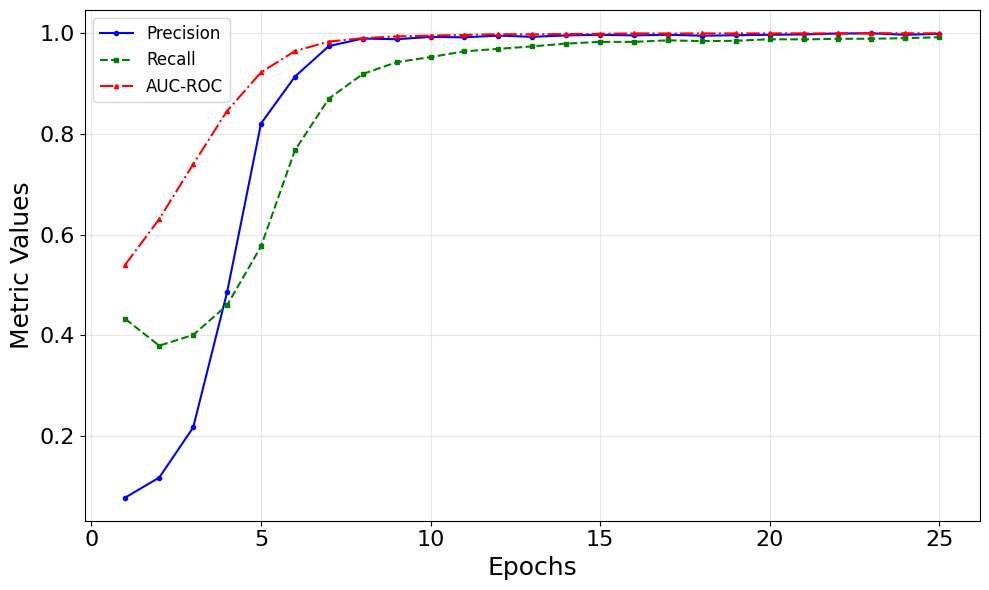

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for precision, recall, and AUC-ROC (replace these with your actual values)
epochs = np.arange(1, 26)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision_values, label='Precision', color='blue', marker='o', markersize=3, linestyle='-')
plt.plot(epochs, recall_values, label='Recall', color='green', marker='s', markersize=3, linestyle='--')
plt.plot(epochs, auc_roc_values, label='AUC-ROC', color='red', marker='^', markersize=3, linestyle='-.')

# Add titles and labels
#plt.title('Performance Metrics Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Metric Values', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the saved state_dict, ignoring missing keys
model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_70_percent_alpha_03.pth'), strict=False)

<ipython-input-70-75698393c95d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_70

<All keys matched successfully>

In [ ]:
# Plot for Training Set
plot_log_likelihoods(model, train_loader, device, dataset_name="Training")

# Plot for Validation Set
#plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")


In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")

In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, test_loader, device, dataset_name="Test")

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, loader, device, dataset_name="Dataset"):
    """
    This function visualizes the latent space by extracting embeddings from the model
    for each batch in 'loader'. We'll handle 3 batch-size scenarios:
      1) 5 items: (x1, x2, labels, x1_mask, x2_mask)
      2) 3 items: (x1, x2, labels)
      3) 2 items: (features, labels)
    We'll assume the model has a method 'get_embeddings(x1, x2, mask1, mask2)'
    that returns an embedding (e.g. shape (batch_size, embed_dim)).
    """

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch

    model.eval()

    all_embeddings = []
    all_labels     = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 5:
                # (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # We'll call some method get_embeddings() if your model has it
                embeddings = model.get_embeddings(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 3:
                # (padded_x1, padded_x2, batch_labels)
                padded_x1, padded_x2, batch_labels = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                embeddings = model.get_embeddings(padded_x1, padded_x2)

            elif len(batch) == 2:
                # (features, labels)
                features, batch_labels = batch

                features = features.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                # If model expects two inputs, pass features twice
                # or adapt if your model uses a single input in get_embeddings
                embeddings = model.get_embeddings(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Convert embeddings + labels to CPU
            emb_np = embeddings.cpu().numpy()
            lbl_np = batch_labels.cpu().numpy()

            all_embeddings.append(emb_np)
            all_labels.append(lbl_np)

    # Concat all
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # shape (total_samples, embed_dim)
    all_labels     = np.concatenate(all_labels,     axis=0)  # shape (total_samples,)

    # Suppose we do a 2D visualization via e.g. TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    emb_2d = tsne.fit_transform(all_embeddings)

    # Plot
    plt.figure(figsize=(8,6))
    # separate normal vs anomaly for coloring
    normal_mask  = (all_labels == 0)
    anomaly_mask = (all_labels == 1)

    plt.scatter(emb_2d[normal_mask,0],  emb_2d[normal_mask,1],  c='blue',  alpha=0.5, label='Normal')
    plt.scatter(emb_2d[anomaly_mask,0], emb_2d[anomaly_mask,1], c='red',   alpha=0.5, label='Anomaly')

    plt.title(f"Latent Space Visualization - {dataset_name}")
    plt.legend()
    plt.show()


In [ ]:
# Visualize the latent space for the training set
#visualize_latent_space(model, train_loader, device, dataset_name="Train")

# Visualize the latent space for the test set
visualize_latent_space(model, val_loader, device, dataset_name="Validation")
